In [1]:
"""Import Statements"""
import fileops as fo
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DIRECTORY_PATH = 'tspset1_heuristics/'

# Get filenames of heuristics and approximation results
heuristics = {}
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]

for filename in filenames:
    heuristics[filename.replace('.json', '')] = np.array(fo.load_from_json(DIRECTORY_PATH + filename))


## Histograms of Heuristics

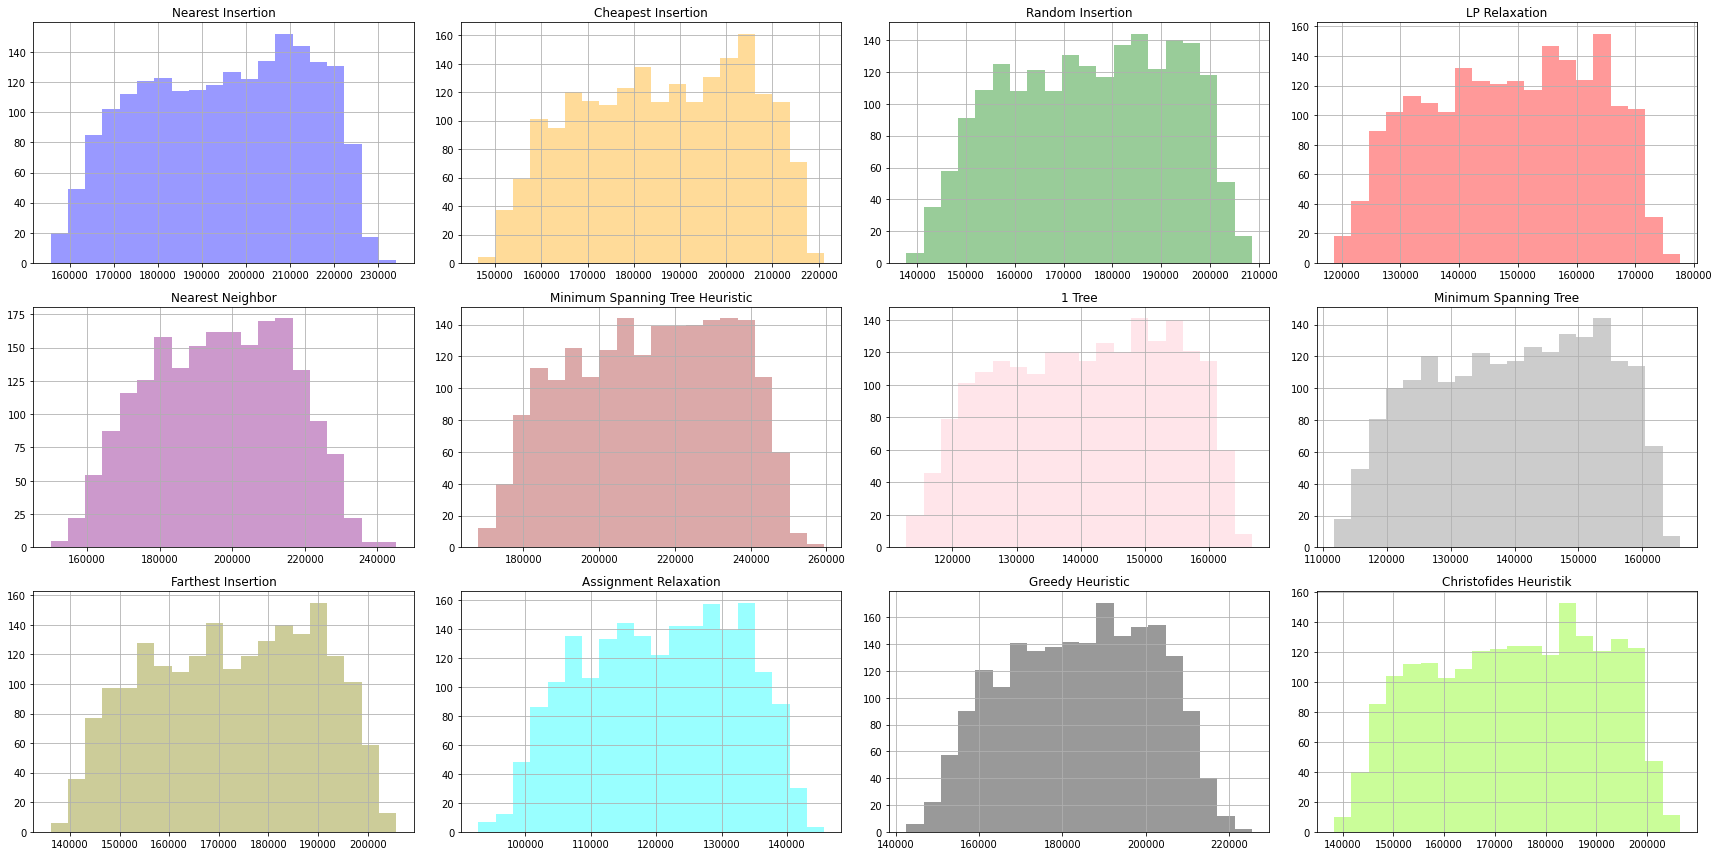

In [3]:
from visualisations.visualise_heuristics_distribution import visualise_heuristics_distribution

heuristics_without_opt = heuristics.copy()
del heuristics_without_opt['opt']
visualise_heuristics_distribution(heuristics_without_opt)

## Histograms of Accuracy of Heuristics in Relation to optimal TSP-Tour

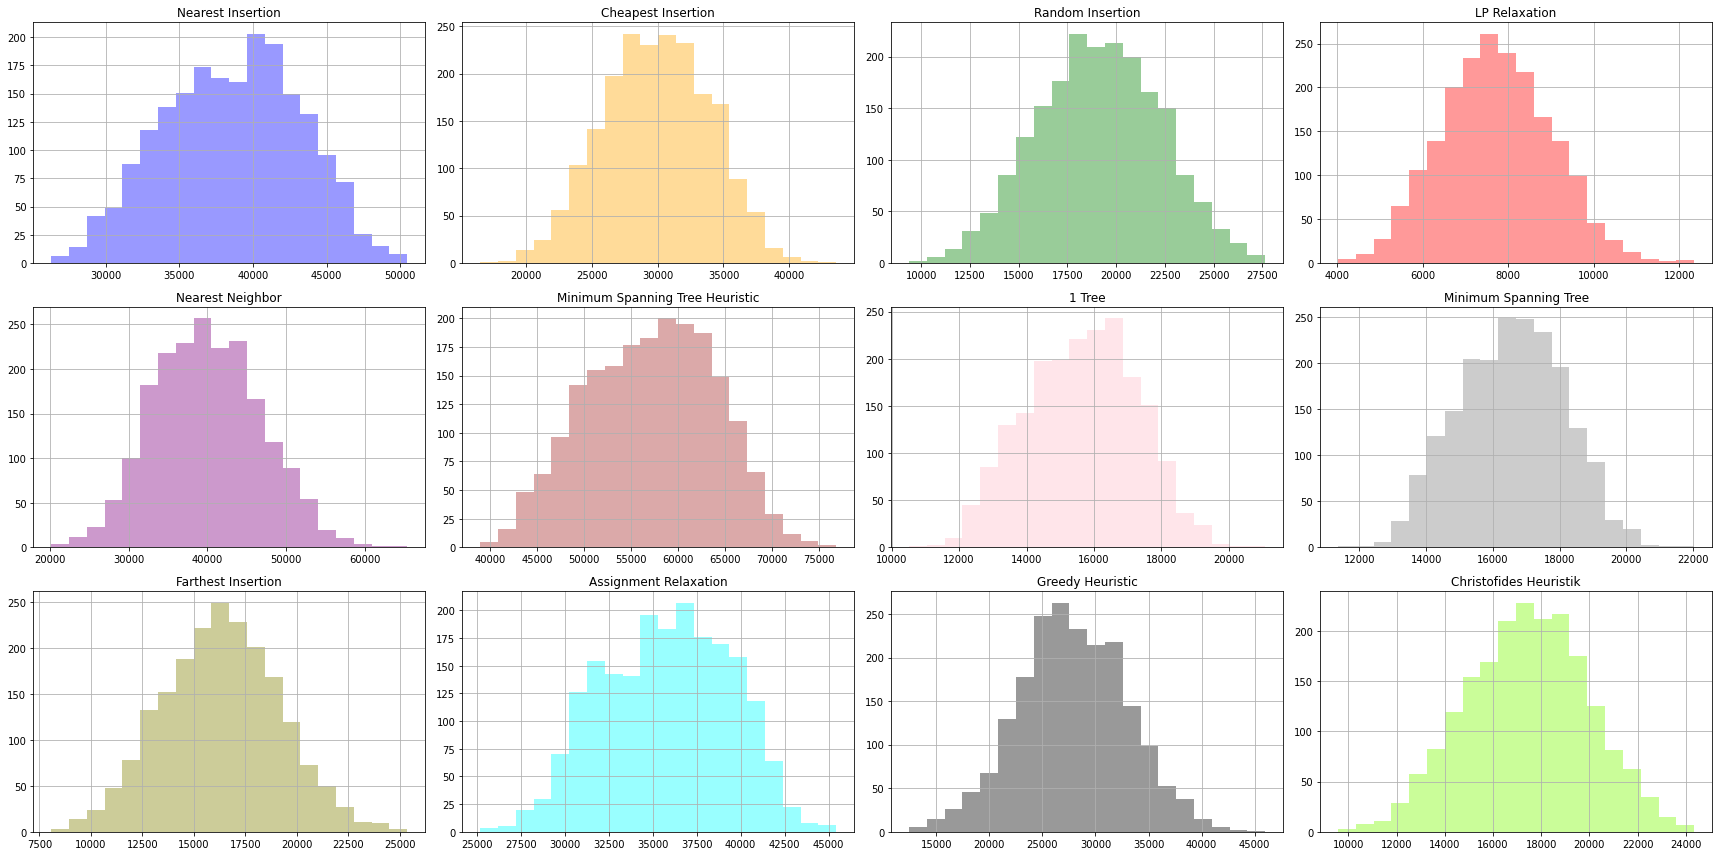

In [4]:
# Find difference of the heuristics to the optimal tour length
distances_from_opt = {}
for key, value in heuristics.items():
    if key == 'opt':
        continue
    distances_from_opt[key] = abs(heuristics['opt'] - value)

visualise_heuristics_distribution(distances_from_opt)

## Percentual deviation from optimal tour costs
Note that here negative values indicate that the heuristic is a lower bound while positive values indicate a heuristic to be an approximatio of the problem solution

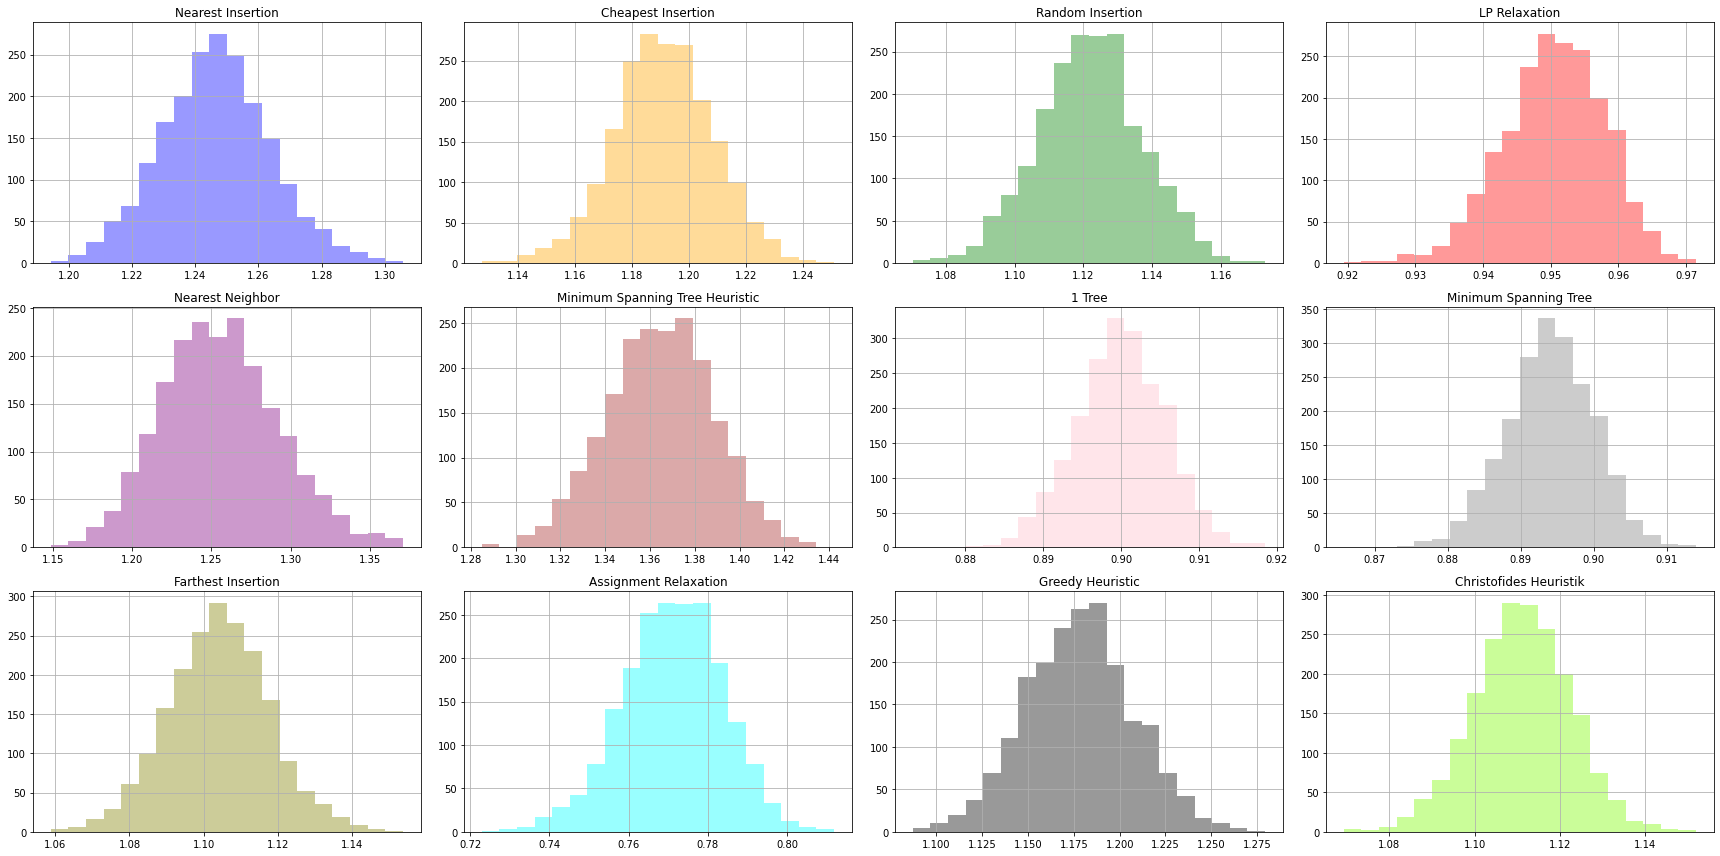

In [5]:
perc_dev_from_opt = {}
for key, value in heuristics.items():
    if key == 'opt':
        continue
    distance = heuristics['opt'] - value
    rel_distance = distance / heuristics['opt']
    perc_dev_from_opt[key] = 1 - rel_distance

visualise_heuristics_distribution(perc_dev_from_opt)

In [6]:
from visualisations.visualise_heuristics_distribution import heuristic_names

devs = {}
for key, value in perc_dev_from_opt.items():
    display_name = heuristic_names[key]
    devs[display_name] = []
    devs[display_name].append(np.median(value))
    devs[display_name].append(np.mean(value))


df = pd.DataFrame(data=devs, index=['Median', 'Mean'])
print(df.T)

                                   Median      Mean
Nearest Insertion                1.246618  1.246526
Cheapest Insertion               1.191330  1.191171
Random Insertion                 1.121979  1.121880
LP Relaxation                    0.950794  0.950505
Nearest Neighbor                 1.254825  1.255869
Minimum Spanning Tree Heuristic  1.365463  1.364788
1 Tree                           0.899955  0.899949
Minimum Spanning Tree            0.894225  0.894054
Farthest Insertion               1.104330  1.104064
Assignment Relaxation            0.771522  0.771156
Greedy Heuristic                 1.178439  1.178128
Christofides Heuristik           1.111340  1.111159


## Visualize a Tour

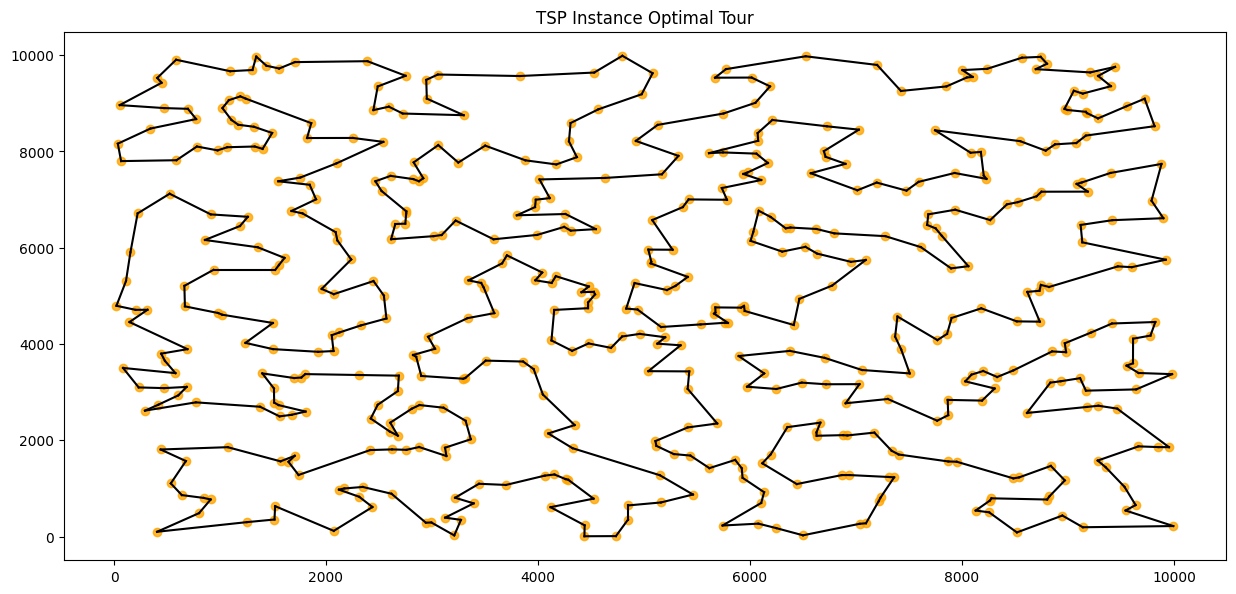

In [7]:
from visualisations import visualise_tour

instance = fo.load_from_json('tspset1/tsp_300_sol.json')

coordinates = np.array(instance['node_coordinates'])

visualise_tour(coordinates, instance['tour'], title='TSP Instance Optimal Tour')

## Heuristics and optimal Tour in relation to Graph size

In [8]:
DIRECTORY_PATH = 'tspset1'

# Get a list of filenames in the directory (excluding subdirectories)
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]

# Sort filenames
filenames.sort(key = lambda name: int(name.replace('tsp_', '').replace('_sol.json','')))

# Read data into memory
instances = []
for filename in filenames:
    instance = fo.load_from_json(DIRECTORY_PATH + '/' + filename)
    instances.append(instance)

In [9]:
# delete illegal heuristics
del heuristics['assrel']
del heuristics['lplb']
del heuristics['ci']

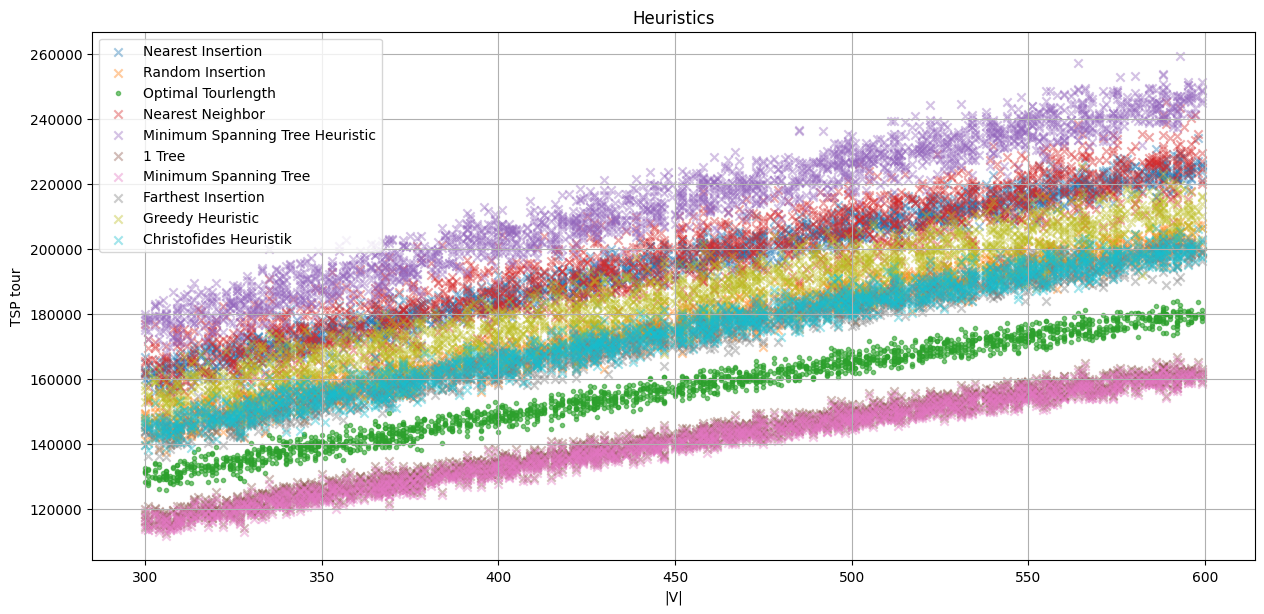

In [10]:
from visualisations.visualise_heuristics import visualise_heuristics

V = [len(x['node_coordinates']) for x in instances]

visualise_heuristics(heuristics, V)

## Regression models trained on the data from the heuristics

In [11]:
# moving into DataFrame structure
df_heuristics = pd.DataFrame(heuristics)

# splitting data
X = df_heuristics.drop(columns=['opt'])
y = df_heuristics['opt']

### Multiple Linear Regression

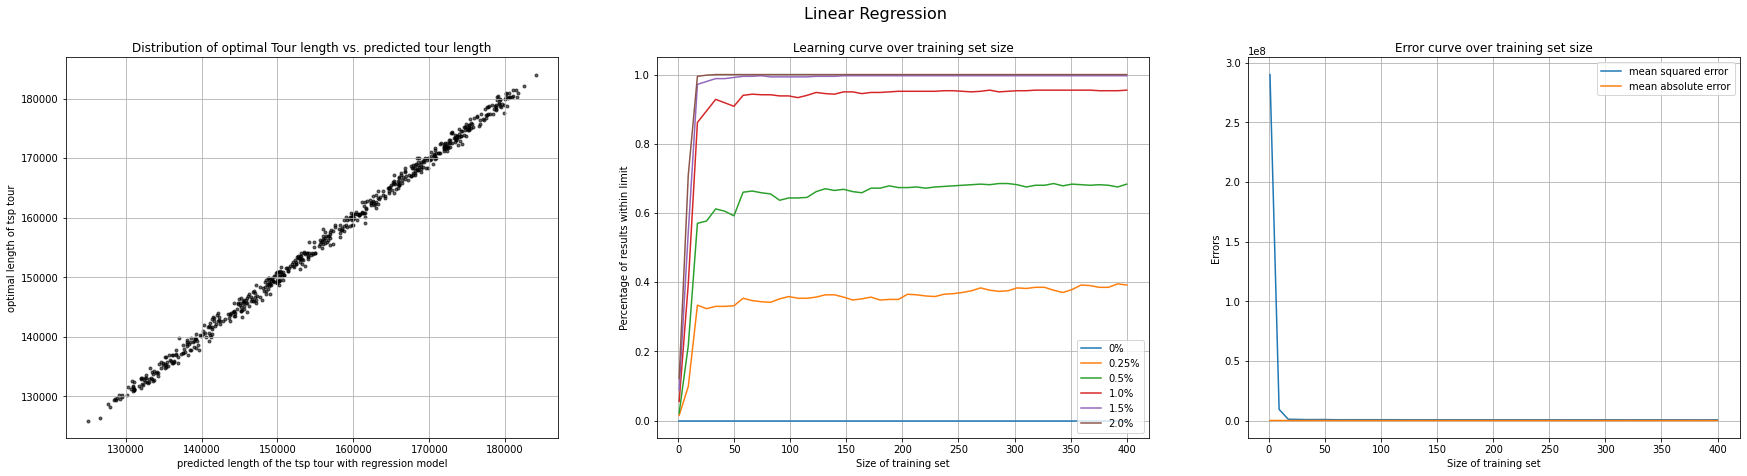

In [12]:
import regressions.regression as rg
from visualisations.visualise_regression import visualise_regression

train_set_size, results, errors = rg.get_instances()

model = LinearRegression()

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Linear Regression')

### Regression Tree

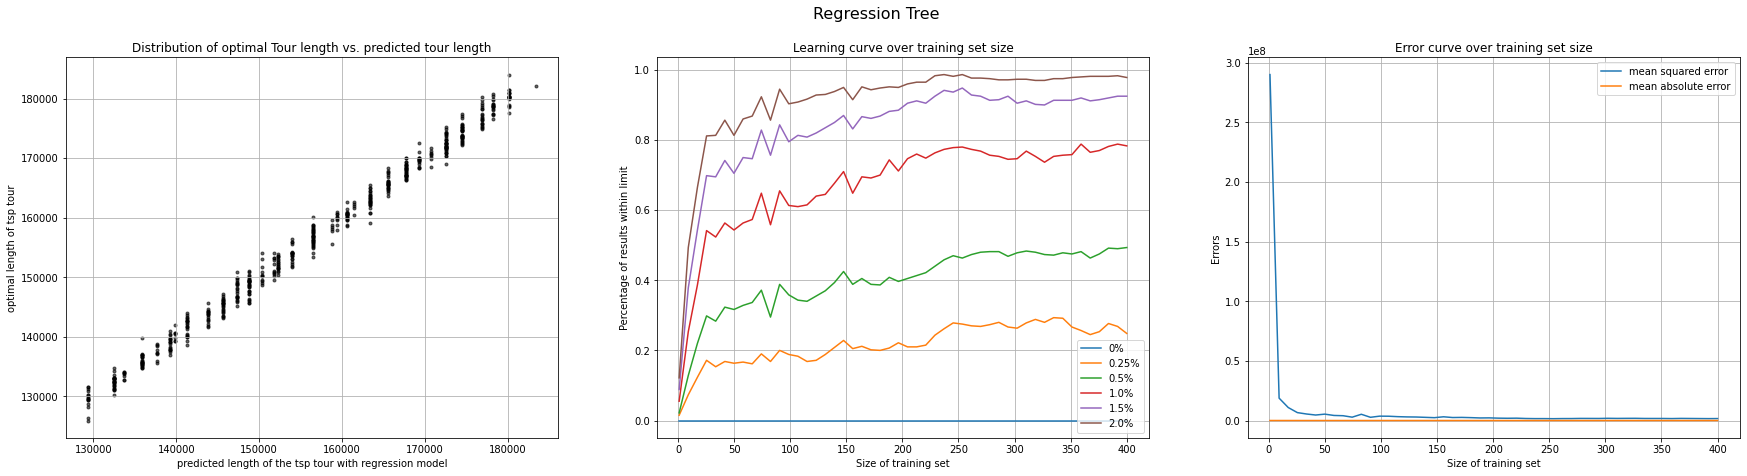

In [13]:
train_set_size, results, errors = rg.get_instances()

model = DecisionTreeRegressor(max_depth=5)

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Regression Tree')

### Neural Network Regression

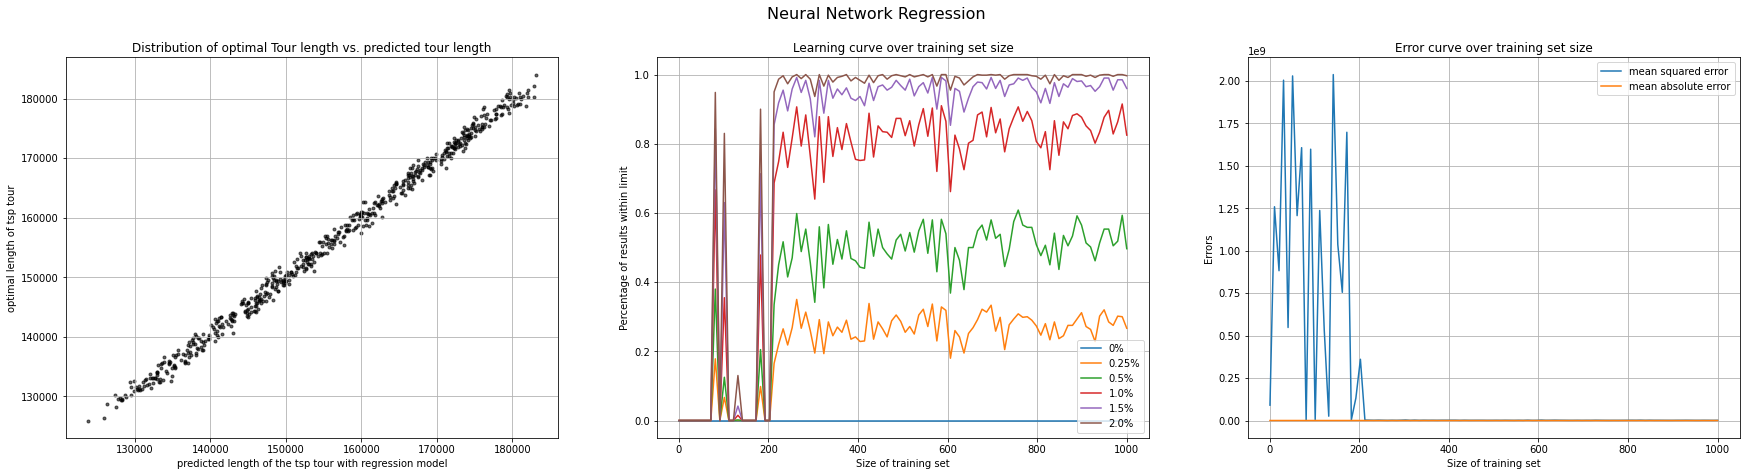

In [14]:
import warnings
warnings.filterwarnings('ignore')

train_set_size, results, errors = rg.get_instances(partition_of_data_set=1/2, number_of_sets=100)

model = MLPRegressor(hidden_layer_sizes=256)

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors, test_size=0.3)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Neural Network Regression')

### Support Vector Regression

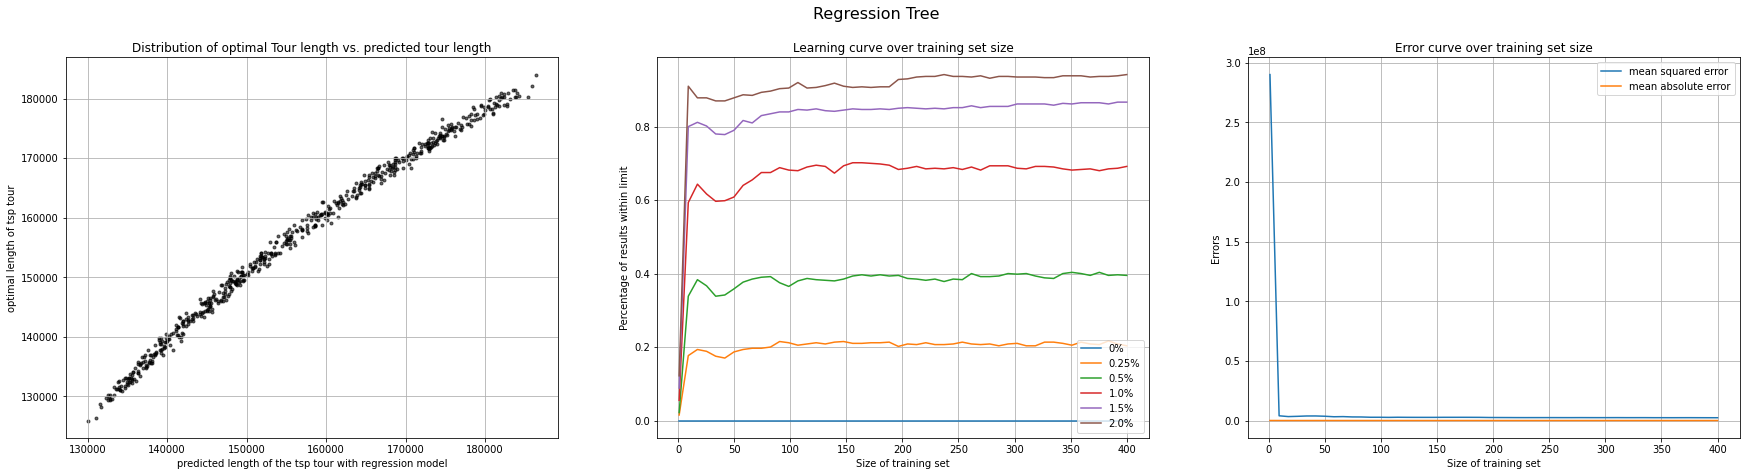

In [15]:
train_set_size, results, errors = rg.get_instances()

model = SVR(kernel='poly')

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Regression Tree')

## Using clustered Data instead

In [17]:
DIRECTORY_PATH = 'tspset2_heuristics/'

# Get filenames of heuristics and approximation results
cluster_heuristics = {}
filenames = [filename for filename in os.listdir(DIRECTORY_PATH)
             if os.path.isfile(os.path.join(DIRECTORY_PATH, filename))]
#filenames = ['greedy.json', 'mst.json', 'mstheu.json', 'nn.json', 'onetree.json', 'opt.json', ]

for filename in filenames:
    cluster_heuristics[filename.replace('.json', '')] = np.array(fo.load_from_json(DIRECTORY_PATH + filename))


In [18]:
instances = [fo.load_from_json(f'tspset2/ctsp_{i}_sol.json') for i in range(2000)]

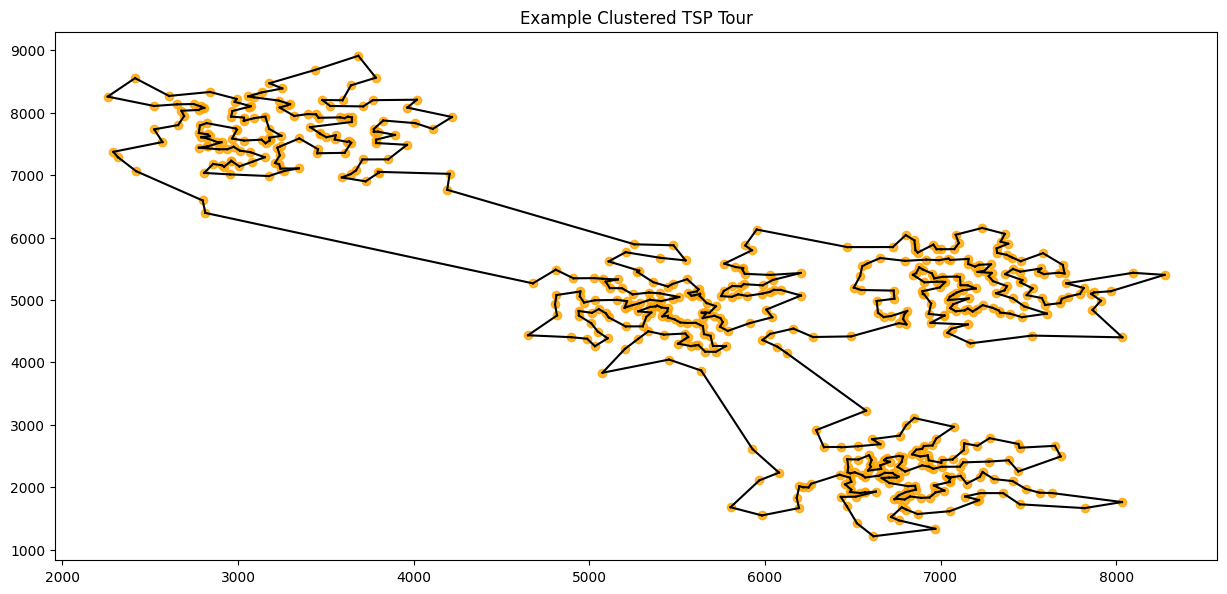

In [20]:
from visualisations.visualise_tour import visualise_tour


instance = instances[22]
coordinates = np.array(instance['node_coordinates'])
tour = np.array(instance['tour'])
visualise_tour(coordinates, tour, title='Example Clustered TSP Tour')

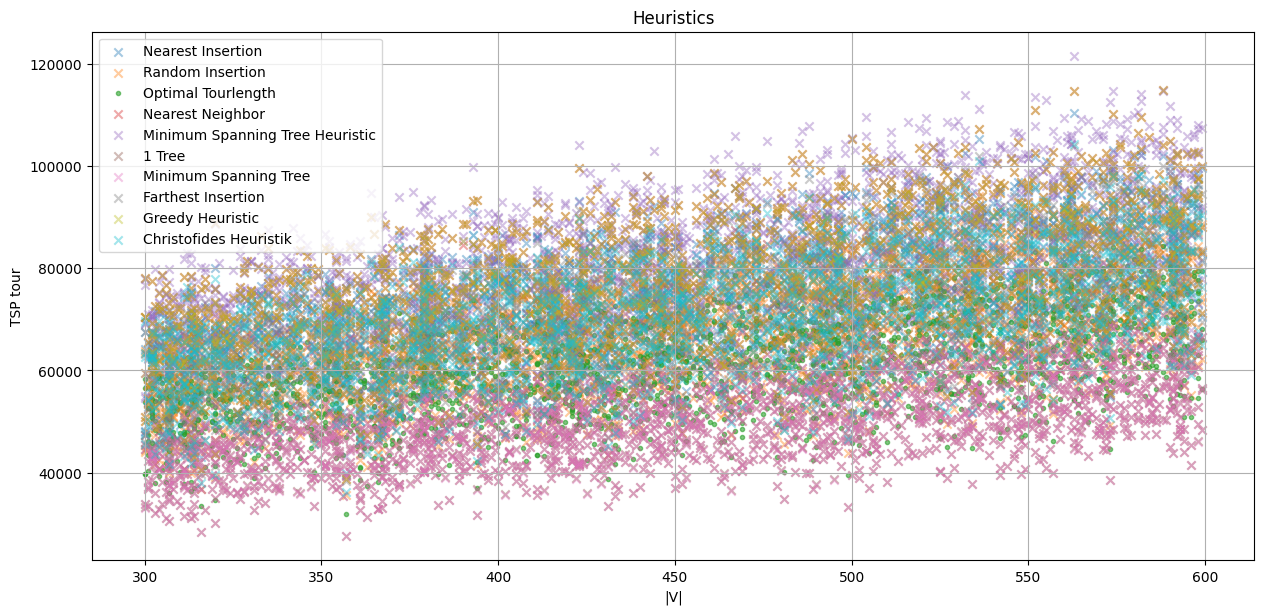

In [21]:
from visualisations.visualise_heuristics import visualise_heuristics

V = [len(x['node_coordinates']) for x in instances]

visualise_heuristics(cluster_heuristics, V)

### Training regression models on clustered data

In [22]:
# moving into DataFrame structure
df_heuristics = pd.DataFrame(cluster_heuristics)

# splitting data
X = df_heuristics.drop(columns=['opt'])
y = df_heuristics['opt']

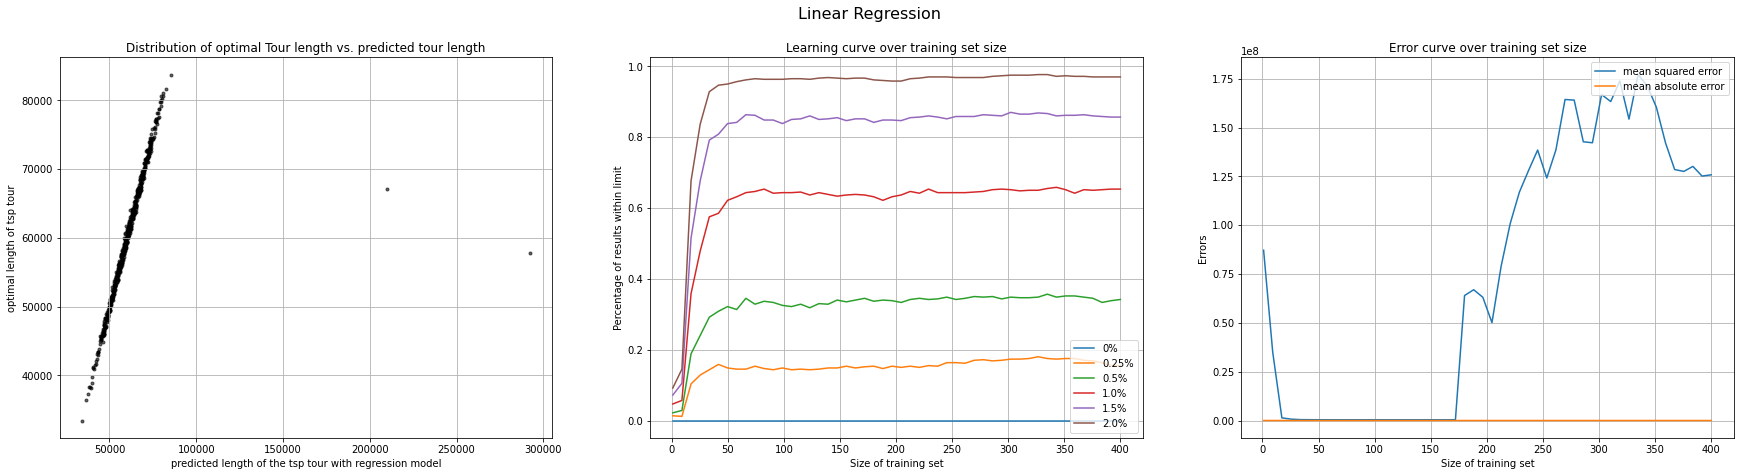

In [23]:
train_set_size, results, errors = rg.get_instances()

model = LinearRegression()

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Linear Regression')

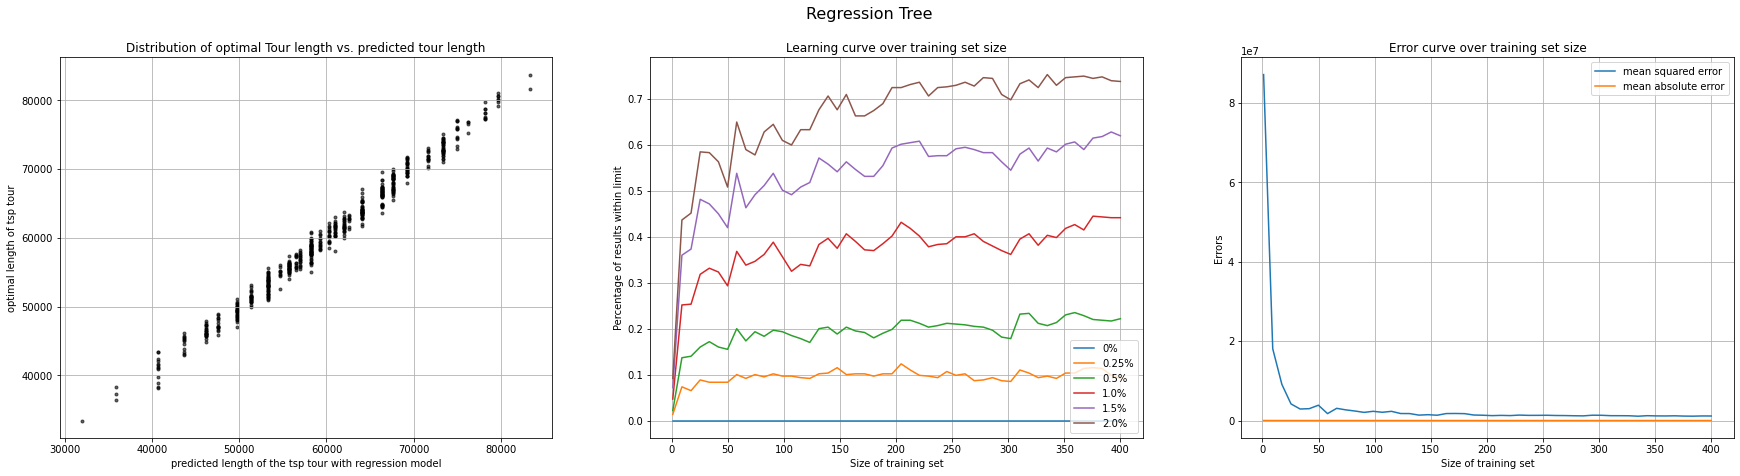

In [24]:
train_set_size, results, errors = rg.get_instances()

model = DecisionTreeRegressor(max_depth=5)

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Regression Tree')

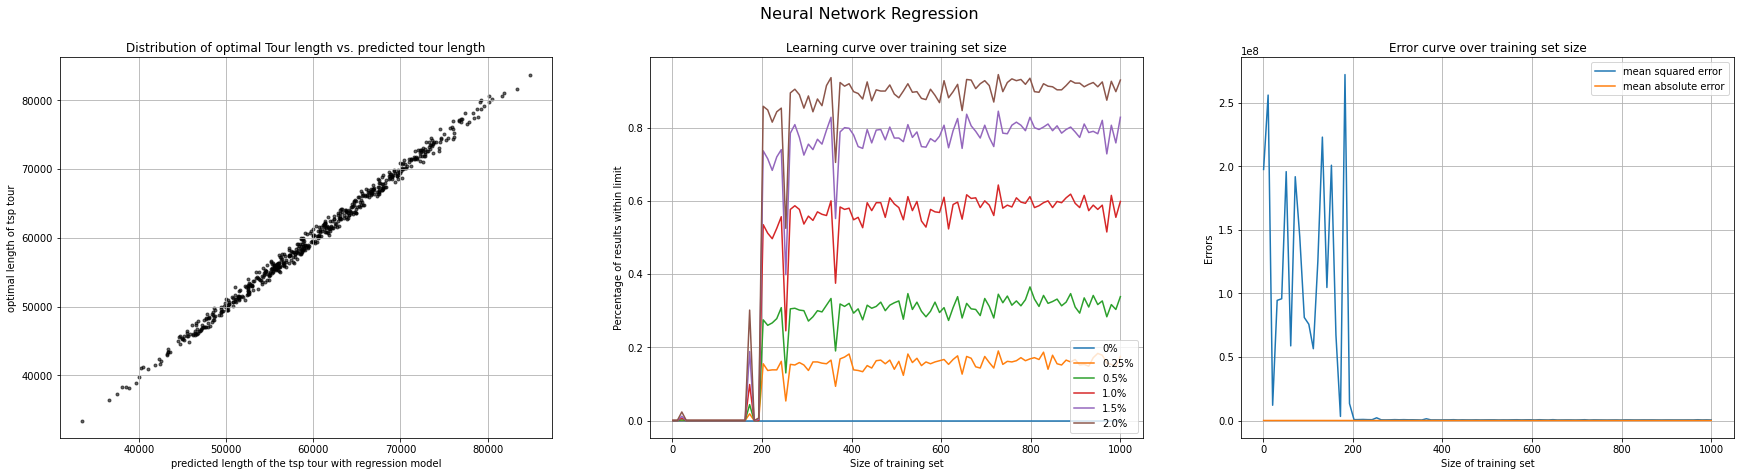

In [25]:
import warnings
warnings.filterwarnings('ignore')

train_set_size, results, errors = rg.get_instances(partition_of_data_set=1/2, number_of_sets=100)

model = MLPRegressor(hidden_layer_sizes=256)

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors, test_size=0.3)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Neural Network Regression')

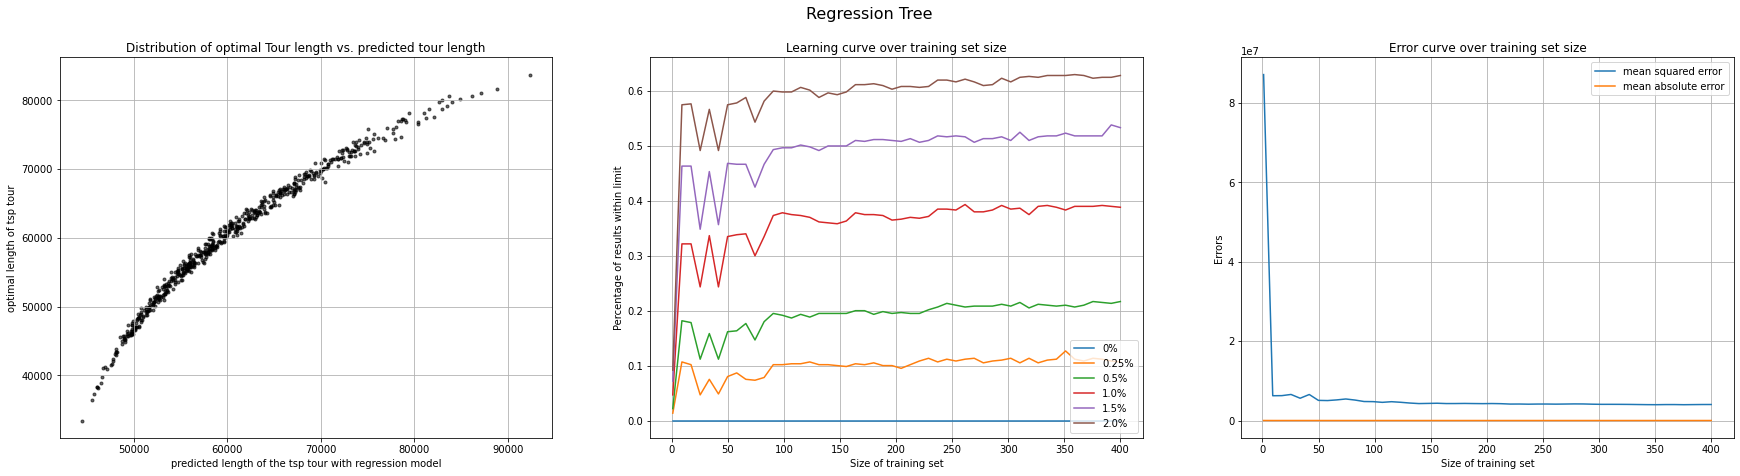

In [26]:
train_set_size, results, errors = rg.get_instances()

model = SVR(kernel='poly')

predictions, y_verify, results, errors = rg.train_models(X, y, model, train_set_size, results, errors)

visualise_regression(predictions, y_verify, results, errors, train_set_size, 'Regression Tree')